In [23]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import time
import string
import re

from itertools import product
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse
from lightfm import LightFM, evaluation, cross_validation, data

from IPython.display import display
pd.options.display.max_columns = None
pd.options.display.max_colwidth = None
pd.options.display.max_rows = None

In [24]:
# @inproceedings{DBLP:conf/recsys/Kula15,
#   author    = {Maciej Kula},
#   editor    = {Toine Bogers and
#                Marijn Koolen},
#   title     = {Metadata Embeddings for User and Item Cold-start Recommendations},
#   booktitle = {Proceedings of the 2nd Workshop on New Trends on Content-Based Recommender
#                Systems co-located with 9th {ACM} Conference on Recommender Systems
#                (RecSys 2015), Vienna, Austria, September 16-20, 2015.},
#   series    = {{CEUR} Workshop Proceedings},
#   volume    = {1448},
#   pages     = {14--21},
#   publisher = {CEUR-WS.org},
#   year      = {2015},
#   url       = {http://ceur-ws.org/Vol-1448/paper4.pdf},
# }

## Some stats on the dataset:
The dataset is split into 1,000 JSON files, each about 35MB; each contains 1,000 complete playlists; therefore there are 1M unique playlists.
Min playlist length is 5.
Max playlist length is 251.
Mean playlist length: 66.346428  
Each playlist has at least 3 unique artists with at least 2 unique albums.  

Total tracks: 66346428  
Total uinque tracks: 2262292  
Top track: HUMBLE. by Kendrick Lamar in 46574 playlists  

Total unique albums: 734684  
Total unique artists: 295860  
Top artist: 847160 tracks by Drake  

## A loop to load JSONs since they're in 1000 different files.

In [25]:
df = []
num_of_JSONs = 10
for x in range(0,num_of_JSONs):
    low = 1000 * x
    high = low + 999
    path = "data/mpd.slice." + str(low) + "-" + str(high) + ".json"
    with open(path) as f:
        file = json.load(f)
        file = file['playlists'] 
        for y in file:
            for z in y['tracks']:
                df.append([z['track_uri'], z['artist_name'], z['track_name'], z['album_name'], y['pid'], y['name']])

## I combined the track artist and title. I added a rating column ('1' for each track in each playlist).

In [26]:
df = pd.DataFrame(df, columns=['Spotify_Track_URI', 'Artist_Name', 'Track_Name', 'Album_Name', 'Playlist_ID', 'Playlist_Name'])
df['Artist_and_Track_Name'] = df['Artist_Name']+' - '+df['Track_Name']
df['Rating']=1
df.head()

,Spotify_Track_URI,Artist_Name,Track_Name,Album_Name,Playlist_ID,Playlist_Name,Artist_and_Track_Name,Rating
0,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,Missy Elliott,Lose Control (feat. Ciara & Fat Man Scoop),The Cookbook,0,Throwbacks,Missy Elliott - Lose Control (feat. Ciara & Fat Man Scoop),1
1,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,Britney Spears,Toxic,In The Zone,0,Throwbacks,Britney Spears - Toxic,1
2,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,Beyoncé,Crazy In Love,Dangerously In Love (Alben für die Ewigkeit),0,Throwbacks,Beyoncé - Crazy In Love,1
3,spotify:track:1AWQoqb9bSvzTjaLralEkT,Justin Timberlake,Rock Your Body,Justified,0,Throwbacks,Justin Timberlake - Rock Your Body,1
4,spotify:track:1lzr43nnXAijIGYnCT8M8H,Shaggy,It Wasn't Me,Hot Shot,0,Throwbacks,Shaggy - It Wasn't Me,1


In [27]:
df.tail()

,Spotify_Track_URI,Artist_Name,Track_Name,Album_Name,Playlist_ID,Playlist_Name,Artist_and_Track_Name,Rating
664707,spotify:track:6ZOPiKQeibCn7fP8dncucL,Keith Urban,Blue Ain't Your Color,Ripcord,9999,Country jams,Keith Urban - Blue Ain't Your Color,1
664708,spotify:track:7pxhKtuTwofDIdgHx2DcVK,Dustin Lynch,Seein' Red,Current Mood,9999,Country jams,Dustin Lynch - Seein' Red,1
664709,spotify:track:7mldq42yDuxiUNn08nvzHO,Sam Hunt,Body Like A Back Road,Body Like A Back Road,9999,Country jams,Sam Hunt - Body Like A Back Road,1
664710,spotify:track:23TxRN09aR1RB0G0tFoT0b,Little Big Town,Better Man,The Breaker,9999,Country jams,Little Big Town - Better Man,1
664711,spotify:track:2TAcwD5KcV9uY3O1tLGV15,Thompson Square,Are You Gonna Kiss Me Or Not,Thompson Square,9999,Country jams,Thompson Square - Are You Gonna Kiss Me Or Not,1


## So there are 170k unique tracks out of 665k total tracks in the first 10 JSONs composing 10k playlists.  This is more than sufficient overlapping tracks to make predictions.

In [28]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Spotify_Track_URI,664712,170089,spotify:track:7KXjTSCq5nL1LoYtL7XAwS,468,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Artist_Name,664712,35637,Drake,8474,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Track_Name,664712,132920,Closer,761,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Album_Name,664712,69059,Views,2071,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Playlist_ID,664712,NaN,NaN,NaN,4971.48,2873.04,0,2479,4957,7451,9999
Playlist_Name,664712,5954,Country,13532,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Artist_and_Track_Name,664712,168069,Kendrick Lamar - HUMBLE.,468,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Rating,664712,NaN,NaN,NaN,1,0,1,1,1,1,1


## Setting up the LightFM model.

In [29]:
dataset = data.Dataset()
# dataset.fit(users=df['Playlist_ID'],items=df['Spotify_Track_URI'], user_features=users_col)
dataset.fit(users=df['Playlist_ID'],items=df['Spotify_Track_URI'])
(interactions, weights) = dataset.build_interactions([(x['Playlist_ID'], x['Spotify_Track_URI'],x['Rating']) for index,x in df.iterrows()])
sparseInt = sparse.csr_matrix(interactions).tocsr()
sparseInt

<10000x170089 sparse matrix of type '<class 'numpy.intc'>'
	with 656152 stored elements in Compressed Sparse Row format>

## Some hyper-param exploration.

In [30]:
def my_grid_searching_function(**param_iterators):
    minutes = time.time()
    keys = list(param_iterators.keys())
    desired_iterator = list(product(*list(param_iterators.values())))
    alpha = []
    l_rate = []
    epochs = []
    no_components = []
    learning_schedule = []
    loss = []
    max_sampled = []
    num_threads = []
    k = []
    random = []
    modduration = []
    testduration = []
    AUCTr = []
    AUCTe = []
    AUCTe3x = [None]*len(desired_iterator)
    precTr = []
    precTe = []
    recaTr = []
    recaTe = []
    recipTr = []
    recipTe = []
    recipTe3x = [None]*len(desired_iterator)
    
    for i in range(len(desired_iterator)):
        alpha.append(desired_iterator[i][0])
        l_rate.append(desired_iterator[i][1])
        epochs.append(desired_iterator[i][2])
        no_components.append(desired_iterator[i][3])
#         learning_schedule.append(desired_iterator[i][4])
#         loss.append(desired_iterator[i][5])
        max_sampled.append(desired_iterator[i][6])
#         num_threads.append(desired_iterator[i][7])
#         k.append(desired_iterator[i][8])
        random.append(desired_iterator[i][9])
#         kk = desired_iterator[i][8]
        
        
        modstart = time.time()        
        
        model = LightFM(
            user_alpha = desired_iterator[i][0],
            item_alpha = desired_iterator[i][0],
            learning_rate = desired_iterator[i][1],
            no_components = desired_iterator[i][3],
            learning_schedule = desired_iterator[i][4],
            loss = desired_iterator[i][5],
            max_sampled = desired_iterator[i][6]
        )
        
        train, test = cross_validation.random_train_test_split(sparseInt, test_percentage=0.2, random_state=desired_iterator[i][9])
        model = model.fit(
            train, 
            epochs = desired_iterator[i][2], 
            verbose=True, 
            num_threads=desired_iterator[i][7]
        ) 
        
        modduration.append(time.time() - modstart)
        teststart = time.time()   

        AUCTr.append(evaluation.auc_score(model, train).mean())
#         precTr.append(evaluation.precision_at_k(model, train, k=kk).mean())
        recipTr.append(1/np.median(evaluation.reciprocal_rank(model, train)))
#         recaTr.append(evaluation.recall_at_k(model, train, k=kk).mean())

        AUCTe.append(evaluation.auc_score(model, test, train_interactions=train).mean())
#         precTe.append(evaluation.precision_at_k(model, test, k=kk, train_interactions=train).mean())
        recipTe.append((1/np.median(evaluation.reciprocal_rank(model, test, train_interactions=train))))
#         recaTe.append(evaluation.recall_at_k(model, test, k=kk, train_interactions=train).mean())
        
        testduration.append(time.time() - teststart)
        

    compareTable = pd.DataFrame(
        data=np.array([
#             iteration,
            alpha,
            l_rate,
            epochs,
            no_components,
            max_sampled,
#             k, 
            random,
            modduration,
            testduration,
            AUCTr,
            AUCTe,
#             AUCTe3x,
#             precTr,
#             precTe,
#             recaTr,
#             recaTe,
            recipTr,
            recipTe
#             recipTe3x
        ]).T,         
        columns=[
#             'iteration',
            'alpha',
            'L_rate',
            'ep',
            'comp',
            'max_sampled',
#             'k', 
            'rand',
            'model time (m)',
            'eval time (m)',
            'AUCTr',
            'AUCTe',
#             'AUCTe3x',
#             'precTr',
#             'precTe',
#             'recaTr',
#             'recaTe',
            'recipTr',
            'recipTe'
#             'recipTe3x'
        ])

    compareTable = compareTable.astype('float') 
#     for x in range(0,len(compareTable.index),2):
#         compareTable.loc[[x,x+1],'AUCTe3x'] = compareTable['AUCTe'].loc[[x,x+1]].mean(axis=0)

    compareTable.ep = compareTable.ep.astype('uint16')
    compareTable.comp = compareTable.comp.astype('uint32')
    compareTable.max_sampled = compareTable.max_sampled.astype('uint8')
#     compareTable.k = compareTable.k.astype(np.uint8)
    compareTable.rand = compareTable.rand.astype('uint16')
    compareTable['model time (m)'] = (compareTable['model time (m)']/60).round(1)
    compareTable['eval time (m)'] = (compareTable['eval time (m)']/60).round(1)
    compareTable.AUCTr = compareTable.AUCTr.round(3)
    compareTable.AUCTe = compareTable.AUCTe.round(3)
#     compareTable.AUCTe3x = compareTable.AUCTe3x.round(3)
#     compareTable.precTr = compareTable.precTr.astype(float).round(3)
#     compareTable.precTe = compareTable.precTe.astype(float).round(3)
#     compareTable.recaTr = compareTable.recaTr.astype(float).round(3)
#     compareTable.recaTe = compareTable.recaTe.astype(float).round(3)
#     compareTable.alpha = compareTable['alpha']

#     for x in range(0,len(compareTable.index),2):
#         compareTable.loc[[x,x+1],'recipTe3x'] = np.median(compareTable['recipTe'].loc[[x,x+1]])
    compareTable.recipTr = compareTable['recipTr'].round(0).astype('uint32')
    compareTable.recipTe = compareTable['recipTe'].round(0).astype('uint32')
#     compareTable.recipTe3x = compareTable['recipTe3x'].round(0).astype('uint32')
    compareTable = compareTable.sort_values(by=['recipTe','AUCTe'],ascending=[True,False])
    
    minutes = (time.time()-minutes)/60
    print("Total time: {0:.1f} minutes".format(minutes))
    
    return(compareTable, model)

### Test

In [ ]:
compareTable, model = my_grid_searching_function(
    alpha = [.00000001],
    l_rate = [.05],
    epochs = [1],
    no_components = [1],
    learning_schedule = ['adagrad'],
    loss = ['warp'],
    max_sampled = [2],
    num_threads = [4],
    k = [5],
    random = [123]
)
compareTable

Epoch: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


### Epochs

In [38]:
compareTable, model = my_grid_searching_function(
    alpha = [0],
    l_rate = [.055],
    epochs = [30,50,70],
    no_components = [200],
    learning_schedule = ['adagrad'],
    loss = ['warp'],
    max_sampled = [50],
    num_threads = [4],
    k = [5],
    random = [123]
)
compareTable

Epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [16:13<00:00, 13.90s/it]


Total time: 138.4 minutes


,alpha,L_rate,ep,comp,max_sampled,rand,model time (s),eval time (m),AUCTr,AUCTe,recipTr,recipTe
2,0.0,0.055,70,200,50,123,974.0,33.4,1.0,0.843,1,18
0,0.0,0.055,30,200,50,123,497.4,34.6,1.0,0.845,1,19
1,0.0,0.055,50,200,50,123,756.2,33.3,1.0,0.845,1,19


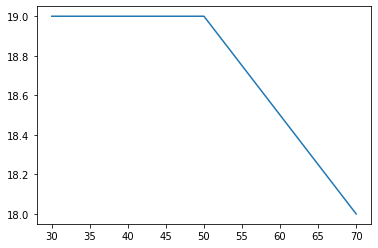

In [39]:
compareTable = compareTable.sort_index(axis = 0)
plt.plot(compareTable.ep,compareTable.recipTe)
plt.show()

### Number of Components

In [23]:
compareTable, model = my_grid_searching_function(
    alpha = [0],
    l_rate = [.055],
    epochs = [50],
    no_components = [100,200,500],
    learning_schedule = ['adagrad'],
    loss = ['warp'],
    max_sampled = [50],
    num_threads = [4],
    k = [5],
    random = [123]
)
compareTable

Epoch: 100%|███████████████████████████████████████████████████████████████████████████| 50/50 [23:15<00:00, 27.92s/it]


Total time: 170.3 minutes


,alpha,L_rate,ep,comp,max_sampled,rand,model time (s),eval time (m),AUCTr,AUCTe,recipTr,recipTe
1,0.0,0.055,50,200,50,123,704.7,33.3,1.0,0.844,1,18
0,0.0,0.055,50,100,50,123,422.3,19.6,1.0,0.844,1,19
2,0.0,0.055,50,500,50,123,1397.4,75.3,1.0,0.844,1,21


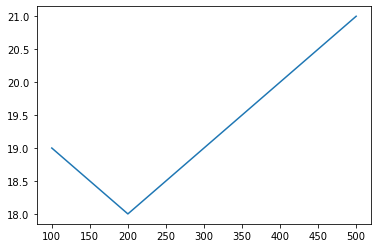

In [24]:
compareTable = compareTable.sort_index(axis = 0)
plt.plot(compareTable.comp,compareTable.recipTe)
plt.show()

### Max Sampled

In [48]:
compareTable, model = my_grid_searching_function(
    alpha = [0],
    l_rate = [.055],
    epochs = [50],
    no_components = [200],
    learning_schedule = ['adagrad'],
    loss = ['warp'],
    max_sampled = [10,20,40],
    num_threads = [4],
    k = [5],
    random = [123]
)
compareTable

Epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████| 50/50 [10:58<00:00, 13.17s/it]


Total time: 124.4 minutes


,alpha,L_rate,ep,comp,max_sampled,rand,model time (m),eval time (m),AUCTr,AUCTe,recipTr,recipTe
1,0.0,0.055,50,200,20,123,6.4,34.5,1.0,0.845,1,19
2,0.0,0.055,50,200,40,123,11.0,34.3,1.0,0.845,1,19
0,0.0,0.055,50,200,10,123,3.7,34.5,1.0,0.845,1,20


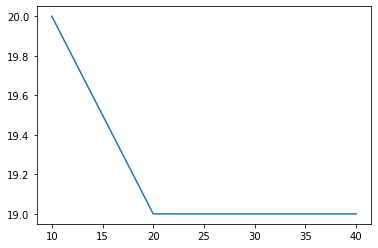

In [49]:
compareTable = compareTable.sort_index(axis = 0)
plt.plot(compareTable.max_sampled,compareTable.recipTe)
plt.show()

### Alpha

In [27]:
compareTable, model = my_grid_searching_function(
    alpha = [0,1e-7,1e-6],
    l_rate = [.055],
    epochs = [50],
    no_components = [200],
    learning_schedule = ['adagrad'],
    loss = ['warp'],
    max_sampled = [50],
    num_threads = [4],
    k = [5],
    random = [123]
)
compareTable

Epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████| 50/50 [13:17<00:00, 15.95s/it]


Total time: 143.3 minutes


,alpha,L_rate,ep,comp,max_sampled,rand,model time (s),eval time (m),AUCTr,AUCTe,recipTr,recipTe
2,1.000000e-06,0.055,50,200,50,123,798.0,34.4,1.0,0.844,1,18
0,0.000000e+00,0.055,50,200,50,123,802.5,34.6,1.0,0.844,1,19
1,1.000000e-07,0.055,50,200,50,123,790.4,34.4,1.0,0.844,1,19


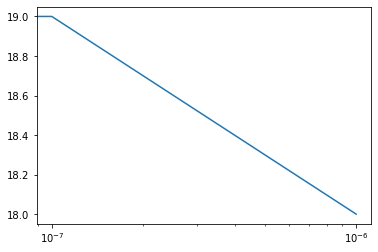

In [28]:
compareTable = compareTable.sort_index(axis = 0)
plt.plot(compareTable.alpha, compareTable.recipTe)
plt.xscale('log')
plt.show()

### Learning Rate

In [29]:
compareTable, model = my_grid_searching_function(
    alpha = [0],
    l_rate = [.045,.055,.06],
    epochs = [50],
    no_components = [200],
    learning_schedule = ['adagrad'],
    loss = ['warp'],
    max_sampled = [50],
    num_threads = [4],
    k = [5],
    random = [123]
)
compareTable

Epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████| 50/50 [12:52<00:00, 15.45s/it]


Total time: 143.2 minutes


,alpha,L_rate,ep,comp,max_sampled,rand,model time (s),eval time (m),AUCTr,AUCTe,recipTr,recipTe
0,0.0,0.045,50,200,50,123,818.9,34.2,1.0,0.852,1,16
1,0.0,0.055,50,200,50,123,799.7,34.5,1.0,0.844,1,18
2,0.0,0.060,50,200,50,123,773.4,34.6,1.0,0.840,1,20


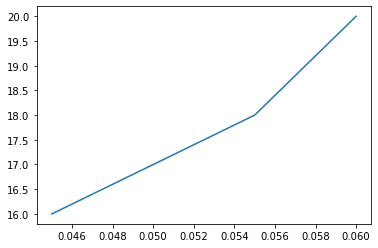

In [30]:
compareTable = compareTable.sort_index(axis = 0)
plt.plot(compareTable.L_rate,compareTable.recipTe)
plt.show()

### Everything

In [20]:
compareTable, model = my_grid_searching_function(
    alpha = [1e-6],
    l_rate = [.045],
    epochs = [30],
    no_components = [200],
    learning_schedule = ['adagrad'],
    loss = ['warp'],
    max_sampled = [20],
    num_threads = [4],
    k = [5],
    random = [123]
)
compareTable

Epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████| 30/30 [04:02<00:00,  8.10s/it]


Total time: 36.5 minutes


,alpha,L_rate,ep,comp,max_sampled,rand,model time (m),eval time (m),AUCTr,AUCTe,recipTr,recipTe
0,0.000001,0.045,30,200,20,123,4.1,32.4,1.0,0.853,1,18


## Predict tracks based on playlist tracks

In [22]:
playlist = 487
num_of_results = 10

In [23]:
track_map = pd.DataFrame(list(dataset.mapping()[2].keys()),columns=['Spotify_Track_URI'])
no_dupe_tracks = df[['Spotify_Track_URI','Artist_and_Track_Name']].copy().drop_duplicates()
track_map = pd.merge(track_map, no_dupe_tracks, how='left', on='Spotify_Track_URI')
track_scores_all = pd.concat([track_map[['Spotify_Track_URI','Artist_and_Track_Name']], pd.Series((model.predict(playlist,np.arange(interactions.shape[1]))), name='Score')],axis=1)
unique_track_list = list((sparseInt[playlist].tocoo()).col)

## Scores for tracks already in playlist

In [24]:
scores_old = track_scores_all[track_scores_all.index.isin(unique_track_list)].copy()
scores_old = scores_old.sort_values(by = ['Score'], ascending=False)
print('Top {0} Tracks Contained in Playlist {1}:'.format(num_of_results,playlist))
print(np.unique(df['Playlist_Name'][df['Playlist_ID']==playlist].values))
scores_old.head(num_of_results)

,Spotify_Track_URI,Artist_and_Track_Name,Score
1874,spotify:track:7BKLCZ1jbUBVqRi2FVlTVw,The Chainsmokers - Closer,5.703903
2074,spotify:track:04DwTuZ2VBdJCCC5TROn7L,Martin Garrix - In the Name of Love,5.150336
1828,spotify:track:0QsvXIfqM0zZoerQfsI9lm,The Chainsmokers - Don't Let Me Down,5.127568
4219,spotify:track:40YcuQysJ0KlGQTeGUosTC,"G-Eazy - Me, Myself & I",4.828067
2400,spotify:track:6DNtNfH8hXkqOX1sjqmI7p,Major Lazer - Cold Water (feat. Justin Bieber & MØ),4.705885
2415,spotify:track:7vRriwrloYVaoAe3a9wJHe,"gnash - i hate u, i love u (feat. olivia o'brien)",4.705589
1880,spotify:track:2rizacJSyD9S1IQUxUxnsK,The Chainsmokers - All We Know,4.673162
1873,spotify:track:6875MeXyCW0wLyT72Eetmo,Hailee Steinfeld - Starving,4.648927
1608,spotify:track:0L7loeTIg6akW84aEQZpCT,Major Lazer - Light It Up (feat. Nyla & Fuse ODG) - Remix,4.631717
2071,spotify:track:5aAx2yezTd8zXrkmtKl66Z,The Weeknd - Starboy,4.600988


## Scores for tracks not in playlist

In [25]:
scores_new = track_scores_all[~track_scores_all.index.isin(unique_track_list)].copy()
scores_new = scores_new.sort_values(by = ['Score'], ascending=False)
print('Top {0} Tracks Not Contained in Playlist {1}:'.format(num_of_results,playlist))
print(np.unique(df['Playlist_Name'][df['Playlist_ID']==playlist].values))
scores_new.head(num_of_results)

,Spotify_Track_URI,Artist_and_Track_Name,Score
2108,spotify:track:4pdPtRcBmOSQDlJ3Fk945m,DJ Snake - Let Me Love You,4.954648
1646,spotify:track:0azC730Exh71aQlOt9Zj3y,Calvin Harris - This Is What You Came For,4.803302
1396,spotify:track:7yyRTcZmCiyzzJlNzGC9Ol,DRAM - Broccoli (feat. Lil Yachty),4.783952
389,spotify:track:78rIJddV4X0HkNAInEcYde,Starley - Call On Me - Ryan Riback Extended Remix,4.731970
2423,spotify:track:6RUKPb4LETWmmr3iAEQktW,The Chainsmokers - Something Just Like This,4.728923
4775,spotify:track:19a3JfW8BQwqHWUMbcqSx8,Kanye West - Famous,4.644688
1782,spotify:track:6WhzFzROw3aq3rPWjgYlxr,Kiiara - Gold,4.642915
3716,spotify:track:4OZEu0Vwq0RB2LAq14v99n,DJ Snake - Middle,4.595911
6046,spotify:track:7gHs73wELdeycvS48JfIos,Alan Walker - Faded,4.573922
2073,spotify:track:4pLwZjInHj3SimIyN9SnOz,Ariana Grande - Side To Side,4.566990


## Predict playlists based on track

In [26]:
track = 'spotify:track:7BKLCZ1jbUBVqRi2FVlTVw'
track_num = int(track_map[track_map['Spotify_Track_URI']==track].index.values)
num_of_results = 10

In [27]:
playlist_map = pd.DataFrame(list(dataset.mapping()[1].keys()),columns=['Playlist_ID'])
no_dupe_playlists = df[['Playlist_ID','Playlist_Name']].copy().drop_duplicates()
playlist_map = pd.merge(playlist_map, no_dupe_playlists, how='left', on='Playlist_ID').drop(columns=['Playlist_ID'])
playlist_scores_all = pd.concat([playlist_map, pd.Series((model.predict(np.arange(interactions.shape[0]),np.repeat(track_num,interactions.shape[0]))), name='Score')],axis=1)

playlists_w_track=[]
for x in range(len(dataset.mapping()[1])):
    if np.in1d(sparseInt[x].tocoo().col,track_num).any():
        playlists_w_track.append(x)       

playlist_scores_old = playlist_scores_all[playlist_scores_all.index.isin(playlists_w_track)].copy()
playlist_scores_old = playlist_scores_old.sort_values(by = ['Score'], ascending=False)
    
print('Top {0} Playlists That Contain Track {1}:'.format(num_of_results,track_num))
print(df['Playlist_Name'].loc[track_num].values)
playlist_scores_old.head(num_of_results)

Top 10 Playlists That Contain Track 1874:
['spotify:track:7BKLCZ1jbUBVqRi2FVlTVw' 'The Chainsmokers - Closer']


,Playlist_Name,Score
2363,Workout,5.933824
5922,Stressed Out,5.831321
4480,down under,5.715993
2394,Mello,5.707238
487,Good stuff,5.703903
8244,party,5.635273
7267,Hype,5.596023
2157,Martin,5.587337
5028,ready,5.484176
6132,Werk,5.415586


In [28]:
playlist_scores_new = playlist_scores_all[~playlist_scores_all.index.isin(playlists_w_track)].copy()
playlist_scores_new = playlist_scores_new.sort_values(by = ['Score'], ascending=False)
    
print("Top {0} Playlists That Don't Contain Track {1}:".format(num_of_results,track_num))
print(track_map.loc[track_num].values)
playlist_scores_new.head(num_of_results)

Top 10 Playlists That Don't Contain Track 1874:
['spotify:track:7BKLCZ1jbUBVqRi2FVlTVw' 'The Chainsmokers - Closer']


,Playlist_Name,Score
9378,Dance,5.972789
2564,shower,5.651904
9512,MIX,5.546754
8694,September,5.540960
3662,jams,5.412152
4324,good,5.379470
9934,FIRE PLAYLIST,5.375393
9923,party,5.371667
6754,Others,5.325292
7784,Today's Hits,5.305364
